In [57]:
!nvidia-smi

Sat Nov 26 21:45:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    28W /  70W |   6704MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [58]:
import os

SOURCE_URL = 'https://tcc-ia.s3.sa-east-1.amazonaws.com/data.tar.xz'
IMAGE_DIR = './faces'
TAR_PATH = os.path.join(IMAGE_DIR, os.path.basename(SOURCE_URL))
EXPECTED_IMAGE_COUNT = 5
IMAGES_DIR=IMAGE_DIR+"/all";

%sx mkdir --parents "{IMAGE_DIR}"
if len(os.listdir(IMAGE_DIR)) != EXPECTED_IMAGE_COUNT:
  %sx wget --no-check-certificate -O "{TAR_PATH}" "{SOURCE_URL}"
  %sx tar --extract --file="{TAR_PATH}" --directory="{IMAGE_DIR}"
  %sx rm "{TAR_PATH}"

print(f'The total number of images is: {len(os.listdir(IMAGE_DIR))}')

The total number of images is: 15


In [59]:
import requests
import io, os
import urllib.parse
import pandas as pd
from sklearn.model_selection import train_test_split

BASE_URL = 'https://tcc-ia.s3.sa-east-1.amazonaws.com/photo-user.csv'

def read_csv_from_web(file_name):
  url = urllib.parse.urljoin(BASE_URL, file_name)
  content = requests.get(url).content
  return pd.read_csv(io.StringIO(content.decode('utf-8')))

train_df, test_df = train_test_split(read_csv_from_web('photo-user.csv'), train_size=0.8)

print(train_df.shape, test_df.shape)
train_df.head(3)

(12, 2) (3, 2)


,code,image_url
13,Camila,camila-004
9,Renan,renan-005
12,Camila,camila-003


In [60]:
!pip install -q --upgrade fastcore fastai
!pip install -q efficientnet_pytorch

In [77]:
import random
import numpy as np
import gc
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from efficientnet_pytorch import EfficientNet

In [62]:
train_df_orig = train_df.copy()

In [63]:
import fastai
print(fastai.__version__ )

2.7.10


In [64]:
from fastai.vision.all import *

In [65]:
def random_seed(seed_value, use_cuda): 
    np.random.seed(seed_value)
    torch.manual_seed(seed_value) 
    random.seed(seed_value)

    if use_cuda: 
        torch.cuda.manual_seed(seed_value) 
        torch.cuda.manual_seed_all(seed_value) 

        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False 

In [66]:
random_seed(2022,True)

In [67]:
train_df.tail()

,code,image_url
14,Camila,camila-005
8,Renan,renan-004
6,Renan,renan-002
3,Daniel,daniel-004
0,Daniel,daniel-001


In [68]:
train_df["image_url"] = ["/content/faces/"+i+".jpg" for i in train_df["image_url"]]

In [69]:
train_df.head()

,code,image_url
13,Camila,/content/faces/camila-004.jpg
9,Renan,/content/faces/renan-005.jpg
12,Camila,/content/faces/camila-003.jpg
5,Renan,/content/faces/renan-001.jpg
10,Camila,/content/faces/camila-001.jpg


In [97]:
faces = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    splitter=TrainTestSplitter(0.2, stratify=train_df["code"]),
  get_x = ColReader(1),
  item_tfms=Resize((320,320), method='squish'),
    get_y=ColReader(0),
    batch_tfms = [
        *aug_transforms(
            do_flip=True,
            flip_vert=False,
            max_lighting=0.4,
            max_zoom=1.2,
            max_warp=0.2,
            max_rotate=30,
            xtra_tfms=None
          ),
        Normalize.from_stats(*imagenet_stats)
      ]
    )

In [70]:
train_df.tail()

In [71]:
dls = faces.dataloaders(train_df, bs=5, num_workers = 0)

In [72]:
train_df.tail()

,code,image_url
14,Camila,/content/faces/camila-005.jpg
8,Renan,/content/faces/renan-004.jpg
6,Renan,/content/faces/renan-002.jpg
3,Daniel,/content/faces/daniel-004.jpg
0,Daniel,/content/faces/daniel-001.jpg


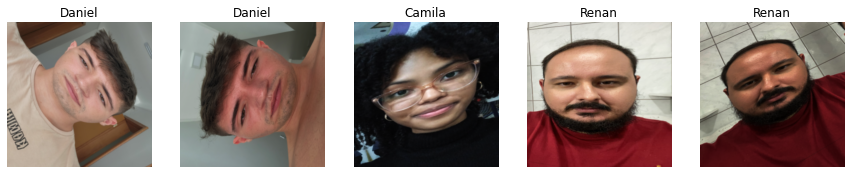

In [73]:
dls.show_batch(max_n=5, nrows=1, ncols=5)

In [74]:
def get_model(dls,pretrained=True, **kwargs):
    model = EfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(model._fc.in_features, dls.c)
    return model

In [75]:
model_name = 'efficientnet-b6'

In [78]:
learn = Learner(dls, get_model(dls), metrics=[error_rate, accuracy])

Loaded pretrained weights for efficientnet-b6


SuggestedLRs(valley=0.0002290867705596611)

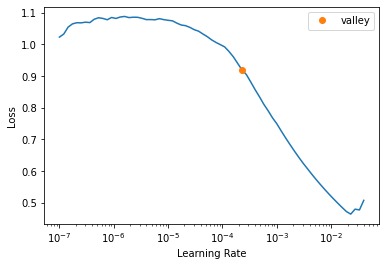

In [79]:
learn.lr_find()

In [80]:
learn.fine_tune(20, cbs= SaveModelCallback(monitor='valid_loss'))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.080215,1.019899,0.333333,0.666667,00:01


Better model found at epoch 0 with valid_loss value: 1.019898533821106.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.040317,0.982907,0.333333,0.666667,00:01
1,0.970819,0.932811,0.333333,0.666667,00:01
2,0.857207,0.859437,0.000000,1.000000,00:01
3,0.831672,0.747556,0.000000,1.000000,00:01
4,0.720926,0.585327,0.000000,1.000000,00:01
5,0.623043,0.386709,0.000000,1.000000,00:01
6,0.541297,0.203613,0.000000,1.000000,00:01
7,0.489397,0.083658,0.000000,1.000000,00:01
8,0.433903,0.033705,0.000000,1.000000,00:01
9,0.391174,0.015862,0.000000,1.000000,00:01


Better model found at epoch 0 with valid_loss value: 0.982907235622406.
Better model found at epoch 1 with valid_loss value: 0.9328112602233887.
Better model found at epoch 2 with valid_loss value: 0.8594372868537903.
Better model found at epoch 3 with valid_loss value: 0.747556209564209.
Better model found at epoch 4 with valid_loss value: 0.5853274464607239.
Better model found at epoch 5 with valid_loss value: 0.38670864701271057.
Better model found at epoch 6 with valid_loss value: 0.20361340045928955.
Better model found at epoch 7 with valid_loss value: 0.08365798741579056.
Better model found at epoch 8 with valid_loss value: 0.03370504453778267.
Better model found at epoch 9 with valid_loss value: 0.01586172543466091.
Better model found at epoch 10 with valid_loss value: 0.008916323073208332.
Better model found at epoch 11 with valid_loss value: 0.005113144405186176.
Better model found at epoch 12 with valid_loss value: 0.003536265343427658.
Better model found at epoch 13 with val

In [81]:
test_df["image_url"]   = ["/content/faces/"+i+".jpg" for i in test_df["image_url"]]

In [82]:
test_df.head()

,code,image_url
7,Renan,/content/faces/renan-003.jpg
11,Camila,/content/faces/camila-002.jpg
4,Daniel,/content/faces/daniel-005.jpg


In [83]:
tdl = learn.dls.test_dl(test_df["image_url"])
test_preds_tta, test_labels_tta = learn.tta(dl=tdl, n=15)

In [84]:
preds_test = test_preds_tta

In [85]:
preds_test

tensor([[2.9421e-03, 2.1128e-05, 9.9704e-01],
        [9.9871e-01, 6.7993e-05, 1.2225e-03],
        [2.1637e-04, 9.9820e-01, 1.5828e-03]])

In [86]:
test_df_copy = test_df

In [87]:
test_df_copy.head()

,code,image_url
7,Renan,/content/faces/renan-003.jpg
11,Camila,/content/faces/camila-002.jpg
4,Daniel,/content/faces/daniel-005.jpg


In [95]:
class_list = learn.dls.vocab
for n in range(3):
  class_indexes2 = []
  for i in range(len(test_df_copy)):
    class_indexes = np.argsort(preds_test, axis=1)[i]
    class_indexes2.append(int(class_indexes[-(n+1)]))
  classes = [class_list[idx] for idx in class_indexes2]


  test_df_copy["prediction{}".format(n+1)] = classes

In [96]:
test_df_copy

,code,image_url,prediction1,prediction2,prediction3
7,Renan,/content/faces/renan-003.jpg,Renan,Camila,Daniel
11,Camila,/content/faces/camila-002.jpg,Camila,Renan,Daniel
4,Daniel,/content/faces/daniel-005.jpg,Daniel,Renan,Camila


In [93]:
learn.export()